# Adssd

+ 使用`TSpectrum`寻峰，记录下寻到的峰位，对应代码中的`peaks`
+ 将所有峰位进行组合，和$\alpha$源的能量进行线性拟合，保留$\chi^2$最小的峰位组合，对应代码中的`selectPeaks`
+ 得到峰位后，对原来的能谱高斯拟合，得到$\mu$,$\sigma$和$\chi^2$，对应代码中的`gaussFit`
+ 利用高斯拟合得到的峰位，再次和$\alpha$源的能量线性拟合，得到刻度系数$p_0$,$p_1$和拟合的$\chi^2$，对应代码的`calibration`
+ 得到刻度系数后，将道址换算成能量，记录在新的文件中，对应代码中`Analysis`最后一部分（约30行）


## 代码

### Adssd.h

```c++
#ifndef __ADSSD_H__
#define __ADSSD_H__

#include <vector>
#include <queue>
#include <map>
#include <functional>
#include <algorithm>

#include <TCanvas.h>
#include <TPad.h>
#include <TFile.h>
#include <TSpectrum.h>
#include <TPolyMarker.h>
#include <TLatex.h>
#include <TF1.h>
#include <TH1F.h>
#include <TMultiGraph.h>
#include <TGraph.h>
#include <TLegend.h>
#include <TString.h>
#include <TRandom3.h>
#include <TBranch.h>
#include <TFitResult.h>
#include <TArrayD.h>

#include "AdssdBase.h"

class Adssd: public AdssdBase {
public:
	Adssd(TTree *tree, TFile *f = nullptr);
	~Adssd();


	virtual int Analysis(TTree *oopt = nullptr);
	virtual int SetAlpha(int an, const Double_t *ap);
private:
	const int chp;

	TRandom3 *gr;

	Int_t alphaPeakNum;
	const Double_t *alphaPeaks;

	TSpectrum *spectrum;

	TFile *logFile;

	TTree *opt;

	Double_t *ccpe;

	virtual int selectPeaks(std::vector<Double_t> &spe, std::vector<Double_t> &pe);
	virtual int peaks(TH1F *h, std::vector<Double_t> &pe, Double_t thres = 0.05, int backsub = 0);
	virtual int changePeaks(int *cpe, int peaks);
	virtual int gaussFit(TH1F *h, const std::vector<Double_t> &spe, Double_t *par);
	virtual int calibration(Double_t *fitPar, int ch, Double_t &p0, Double_t &p1, Double_t &chi2);
	virtual int setBranch();
};



#endif


```


### Adssd.cpp
```c++
#include "Adssd.h"

using std::vector;

Adssd::Adssd(TTree *tree, TFile *f)
	: AdssdBase(tree)
	, chp(48) {
	alphaPeakNum = 0;
	alphaPeaks = nullptr;
	logFile = f;
	spectrum = new TSpectrum(500);
	gr = new TRandom3(0);
	opt = nullptr;
	ccpe = new Double_t[chp];
	new TCanvas;
}


Adssd::~Adssd() {
	if (alphaPeaks) delete alphaPeaks;
	if (spectrum) delete spectrum;
	if (gr) delete gr;
	delete[] ccpe;
}



int Adssd::peaks(TH1F *h, vector<Double_t> &pe, Double_t thres, int backsub) {
	if (!spectrum) return -1;

	pe.clear();
	std::multimap<Double_t, Double_t> me;

	TH1F *hb = nullptr;
	if (backsub) {
		hb = (TH1F*)spectrum->Background(h, 80, "same");
		h->Add(h, hb, 1, -1);
	}


	Int_t foundNum = spectrum->Search(h, 2, "nodraw", thres);

	TPolyMarker *pm = (TPolyMarker*)h->GetListOfFunctions()->FindObject("TPolyMarker");
	pm->SetMarkerStyle(32);
	pm->SetMarkerColor(kGreen);
	pm->SetMarkerSize(0.4);

	vector<TLatex*> texs;
	Double_t *xPeaks = spectrum->GetPositionX();
	Double_t *yPeaks = spectrum->GetPositionY();
	for (int i = 0; i != foundNum; ++i) {
		TLatex *tex = new TLatex(xPeaks[i], yPeaks[i], TString::Format("%.0lf", xPeaks[i]));
		texs.push_back(tex);
		tex->SetTextFont(13);
		tex->SetTextSize(14);
		tex->SetTextAlign(12);
		tex->SetTextAngle(90);
		tex->SetTextColor(kRed);
		h->GetListOfFunctions()->Add(tex);
		me.insert(std::make_pair(yPeaks[i], xPeaks[i]));
	}

	for (auto ie = me.rbegin(); ie != me.rend(); ++ie) {
		pe.push_back(ie->second);
	}
	me.clear();
	// save
	if (logFile) {
		h->Write();
	}
	for (auto itex : texs) {
		h->GetListOfFunctions()->Remove(itex);
		delete itex;
	}
	return 0;
}


int Adssd::SetAlpha(int an, const Double_t *ap) {
	alphaPeakNum = an;
	alphaPeaks = ap;

	return 0;
}



int Adssd::Analysis(TTree *oopt) {
	opt = oopt;
	if (opt) setBranch();


	fChain->Draw("cpe>>hAll(1000, 0, 2000)", "", "goff");
	TH1F *hAll = (TH1F*)gDirectory->Get("hAll");
	if (logFile) {
		logFile->cd();
		hAll->Write();
	}

	// graph of sigma and chi2 for all strips
	TMultiGraph *mgRes = new TMultiGraph;
	mgRes->SetName("PeakSigma");
	TMultiGraph *mgChi = new TMultiGraph;
	mgChi->SetName("PeakChi2");
	vector<TGraph*> gRes;
	vector<TGraph*> gChi;
	if (logFile) {
		for (int i = 0; i != alphaPeakNum; ++i) {
			TGraph *g = new TGraph;
			g->SetName(TString::Format("sigma %lf", alphaPeaks[i]).Data());
			g->SetMarkerStyle(20+i);
			g->SetMarkerColor(i+1);
			g->SetLineColor(i+1);
			gRes.push_back(g);
			g = new TGraph;
			g->SetName(TString::Format("chi2 %lf", alphaPeaks[i]).Data());
			g->SetMarkerStyle(20+i);
			g->SetMarkerColor(i+1);
			g->SetLineColor(i+1);
			gChi.push_back(g);
		}
	}

	TH1F *hpe[chp];
	TDirectoryFile *pDir[chp];
	Double_t p0[chp], p1[chp], chi2[chp];
	TGraph *gcp0, *gcp1, *gcchi2;

	// calibration
	for (int ch = 0; ch != chp; ++ch) {
		if (logFile) {
			logFile->cd();
			TString dirName;
			dirName.Form("dp%d", ch);
			pDir[ch] = new TDirectoryFile(dirName.Data(), dirName.Data());
			pDir[ch]->cd();
		}
		// generate
		TString hName;
		hName.Form("hpe%d", ch);
		fChain->Draw((TString::Format("cpe[%d]>>", ch)+hName+"(1000, 600, 1600)").Data(), "", "goff");
		hpe[ch] = (TH1F*)gDirectory->Get(hName.Data());

		// find peaks
		vector<Double_t> pe;				// channel of peaks
		peaks(hpe[ch], pe);
		// print
		fprintf(stderr, "%2d: ", ch);
		for (auto ipe : pe) {
			fprintf(stderr, "%.0lf ", ipe);
		}
		fprintf(stderr, "\b\n");


		// select peaks
		vector<Double_t> spe;	// qpe of min chi2
		selectPeaks(spe, pe);

		// gauss fit
		Double_t *fitPar = new Double_t[alphaPeakNum * 3];
		hName.Form("hpeFit%d", ch);
		hpe[ch]->SetName(hName.Data());
		gaussFit(hpe[ch], spe, fitPar);


		// fit and get calibration parameters
		calibration(fitPar, ch, p0[ch], p1[ch], chi2[ch]);

		// save
		if (logFile) {
			for (int i = 0; i != alphaPeakNum; ++i) {
				gRes[i]->SetPoint(ch, ch, fitPar[i*3+1]*p1[ch]);
				gChi[i]->SetPoint(ch, ch, fitPar[i*3+2]);
			}
		}

		pe.clear();
	}

	// save gauss residual and chi2 graphs
	for (int i = 0; i != alphaPeakNum; ++i) {
		mgRes->Add(gRes[i], "PL");
		mgChi->Add(gChi[i], "PL");
	}
	if (logFile) {
		logFile->cd();
		TLegend *legend = new TLegend;
		for (int i = 0; i != alphaPeakNum; ++i) {
			legend->AddEntry(gRes[i], TString::Format("sigma %d", i).Data());
		}
		mgRes->GetListOfFunctions()->Add(legend);
		mgRes->Write();
		legend = new TLegend;
		for (int i = 0; i != alphaPeakNum; ++i) {
			legend->AddEntry(gChi[i], TString::Format("chi2 %d", i).Data());
		}
		mgChi->GetListOfFunctions()->Add(legend);
		mgChi->Write();
	}
	delete mgRes;
	delete mgChi;

	// save calibration parameters
	if (logFile) {
		// Double_t x[chp];
		// for (int i = 0; i != chp; ++i) {
		// 	x[i] = i;
		// }
		TDirectoryFile *dca = new TDirectoryFile("calibration", "calibration");
		dca->cd();
		gcp0 = new TGraph;
		gcp1 = new TGraph;
		gcchi2 = new TGraph;
		for (int i = 0; i != chp; ++i) {
			gcp0->SetPoint(i, i, p0[i]);
			gcp1->SetPoint(i, i, p1[i]);
			gcchi2->SetPoint(i, i, chi2[i]);
		}
		gcp0->SetMarkerStyle(20);
		gcp1->SetMarkerStyle(20);
		gcchi2->SetMarkerStyle(20);
		gcp0->Write("gcp0");
		gcp1->Write("gcp1");
		gcchi2->Write("gcchi2");
		delete gcp0;
		delete gcp1;
		delete gcchi2;
		TArrayD ap0 = TArrayD(chp, p0);
		TArrayD ap1 = TArrayD(chp, p1);
		TArrayD achi2 = TArrayD(chp, chi2);
		dca->WriteObject(&ap0, "cp0");
		dca->WriteObject(&ap1, "cp1");
		dca->WriteObject(&achi2, "cchi2");
	}

	// print calibration parameters
	for (int i = 0; i != chp; ++i) {
		fprintf(stderr, "%d  %lf %lf\n", i, p0[i], p1[i]);
	}

   // calculate energy and fill
	TH1F *hAllFit = new TH1F("hAllFit", "", 1000, 0, 10.0);
	Long64_t nentry = fChain->GetEntries();
	Long64_t nentry100 = nentry / 100;
	fprintf(stderr, "filling   0%%");
	fflush(stderr);
	for (Long64_t jentry = 0; jentry != nentry; ++jentry) {
		fChain->GetEntry(jentry);
		for (int i = 0; i != chp; ++i) {
			ccpe[i] = p0[i] + p1[i] * cpe[i];
		}
		opt->Fill();
		for (int i = 0; i != chp; ++i) {
			hAllFit->Fill(ccpe[i]);
		}
		if ((jentry+1) % (nentry100) == 0) {
			fprintf(stderr, "\b\b\b\b%3lld%%", (jentry+1)/nentry100);
			fflush(stderr);
		}
	}
	fprintf(stderr, "\n");

	if (logFile) {
		logFile->cd();
		hAllFit->Write();
	}

	return 0;
}

int Adssd::selectPeaks(vector<Double_t> &spe, vector<Double_t> &pe) {
	std::priority_queue<Double_t, vector<Double_t>, std::greater<Double_t>> qpe;		// selected channels
	Double_t minChi2 = 1e9;					// min chi2


	int *cpe = new int[alphaPeakNum];
	for (int i = 0; i != alphaPeakNum; ++i) {
			cpe[i] = i;
	}
	cpe[alphaPeakNum-1] = alphaPeakNum - 2;
	while (changePeaks(cpe, pe.size())) {
		for (int i = 0; i != alphaPeakNum; ++i) {
			qpe.push(pe[cpe[i]]);
		}
		TGraph *gc = new TGraph;
		for (int i = 0; i != alphaPeakNum; ++i) {
			gc->SetPoint(i, qpe.top(), alphaPeaks[i]);
			qpe.pop();
		}
		TFitResultPtr r = gc->Fit("pol1", "SQ");
		Double_t chi2 = r->Chi2();
		if (chi2 < minChi2) {
			minChi2 = chi2;
			spe.clear();
			for (int i = 0; i != alphaPeakNum; ++i) {
				spe.push_back(pe[cpe[i]]);
			}
		}
	}
	fprintf(stderr, "    chi2 %lf\n", minChi2);

	std::sort(spe.begin(), spe.end());
	delete cpe;
	return 0;
}


int Adssd::changePeaks(int *cpe, int peaks) {
	if (cpe[0] == peaks - alphaPeakNum) return 0;
	for (int i = alphaPeakNum-1; i >= 0; --i) {
		if (cpe[i] < peaks-alphaPeakNum+i) {
			cpe[i] += 1;
			for (int j = i+1; j != alphaPeakNum; ++j) {
				cpe[j] = cpe[j-1] + 1;
			}
			return 1;
		}
	}

	return 0;
}


int Adssd::gaussFit(TH1F *h, const vector<Double_t> &spe, Double_t *par) {
	TF1 **f = new TF1*[alphaPeakNum];
	TFitResultPtr r;
	for (int i = 0; i != alphaPeakNum; ++i) {
		f[i] = new TF1(TString::Format("f%d", i), "gaus", spe[i]-6, spe[i]+12);
		f[i]->SetParameters(h->GetBinContent(spe[i]), spe[i], 5);
		r = h->Fit(f[i], "QSR+");
		par[i*3] = f[i]->GetParameter(1);
		par[i*3+1] = f[i]->GetParameter(2);
		par[i*3+2] = r->Chi2() / r->Ndf();
	}
	// save
	if (logFile) {
		h->Write();
	}
	// for (int i = 0; i != alphaPeakNum; ++i) {
	// 	delete f[i];
	// }
	delete[] f;
	return 0;
}


int Adssd::calibration(Double_t *fitPar, int ch, Double_t &p0, Double_t &p1, Double_t &chi2) {
	// calibration
	TGraph *gc = new TGraph;			// graph for calibration
	for (int i = 0; i != alphaPeakNum; ++i) {
		gc->SetPoint(i, fitPar[i*3], alphaPeaks[i]);
	}
	gc->SetMarkerStyle(20);
	TFitResultPtr r = gc->Fit("pol1", "SQ+");
	TF1 *f1 = gc->GetFunction("pol1");
	p0 = f1->GetParameter(0);
	p1 = f1->GetParameter(1);
	chi2 = r->Chi2() / r->Ndf();

	TGraph *gResidual = new TGraph;			// graph of residual
	gResidual->SetMarkerStyle(20);
	for (int i = 0; i != alphaPeakNum; ++i) {
		gResidual->SetPoint(i, alphaPeaks[i], p0+p1*fitPar[i*3]-alphaPeaks[i]);
	}

	if (logFile) {
		gc->Write(TString::Format("gc%d", ch));
		gResidual->Write(TString::Format("gResidual %d", ch));

	}
	delete gc;
	delete gResidual;

	return 0;
}


int Adssd::setBranch() {
	opt->Branch("ccpe", ccpe, TString::Format("ccpe[%d]/D", chp));
	return 0;
}

```

### main.cpp


```c++
#include "Adssd.h"

const int alphaNum = 4;
const Double_t alphaPeaks[alphaNum] {5.5658, 6.1748, 6.6708, 8.6931};

int main(int argc, char **argv) {
	TFile *ipf = new TFile("../data/s4c.root", "read");
	TTree *ipt = (TTree*)ipf->Get("tree");

	TFile *opf = new TFile("../data/s4calibration.root", "recreate");
	TTree *opt = new TTree("tree", "alpha calibration");

	TFile *logf = new TFile("../data/s4Log.root", "recreate");

	Adssd *ad = new Adssd(ipt, logf);
	ad->SetAlpha(alphaNum, alphaPeaks);

	ad->Analysis(opt);

	opf->cd();
	opt->Write();
	opf->Close();
	logf->Close();
	ipf->Close();

	return 0;
}

```


## 分析


### 寻峰


In [1]:
%jsroot on
TCanvas *c1 = new TCanvas;
TFile *ipf = new TFile("../data/s4Log.root", "read");
ipf->ls();

TFile**		../data/s4Log.root	
 TFile*		../data/s4Log.root	
  KEY: TH1F	hAll;1	cpe
  KEY: TDirectoryFile	dp0;1	dp0
  KEY: TDirectoryFile	dp1;1	dp1
  KEY: TDirectoryFile	dp2;1	dp2
  KEY: TDirectoryFile	dp3;1	dp3
  KEY: TDirectoryFile	dp4;1	dp4
  KEY: TDirectoryFile	dp5;1	dp5
  KEY: TDirectoryFile	dp6;1	dp6
  KEY: TDirectoryFile	dp7;1	dp7
  KEY: TDirectoryFile	dp8;1	dp8
  KEY: TDirectoryFile	dp9;1	dp9
  KEY: TDirectoryFile	dp10;1	dp10
  KEY: TDirectoryFile	dp11;1	dp11
  KEY: TDirectoryFile	dp12;1	dp12
  KEY: TDirectoryFile	dp13;1	dp13
  KEY: TDirectoryFile	dp14;1	dp14
  KEY: TDirectoryFile	dp15;1	dp15
  KEY: TDirectoryFile	dp16;1	dp16
  KEY: TDirectoryFile	dp17;1	dp17
  KEY: TDirectoryFile	dp18;1	dp18
  KEY: TDirectoryFile	dp19;1	dp19
  KEY: TDirectoryFile	dp20;1	dp20
  KEY: TDirectoryFile	dp21;1	dp21
  KEY: TDirectoryFile	dp22;1	dp22
  KEY: TDirectoryFile	dp23;1	dp23
  KEY: TDirectoryFile	dp24;1	dp24
  KEY: TDirectoryFile	dp25;1	dp25
  KEY: TDirectoryFile	dp26;1	dp26
  KEY: TDirectoryFile

In [2]:
TDirectory *dp0 = (TDirectory*)ipf->Get("dp0");
dp0->ls();

TDirectoryFile*		dp0	dp0
 KEY: TH1F	hpe0;1	cpe[0]
 KEY: TH1F	hpeFit0;1	cpe[0]
 KEY: TGraph	gc0;1	
 KEY: TGraph	gResidual 0;1	


In [3]:
TH1F *hpe3 = (TH1F*)ipf->Get("dp3/hpe3");
hpe3->Draw();
c1->Draw();

### 高斯拟合

In [4]:
c1->Clear();
TH1F *hpeFit3 = (TH1F*)ipf->Get("dp3/hpeFit3");
hpeFit3->Draw();
c1->Draw();

### 刻度 

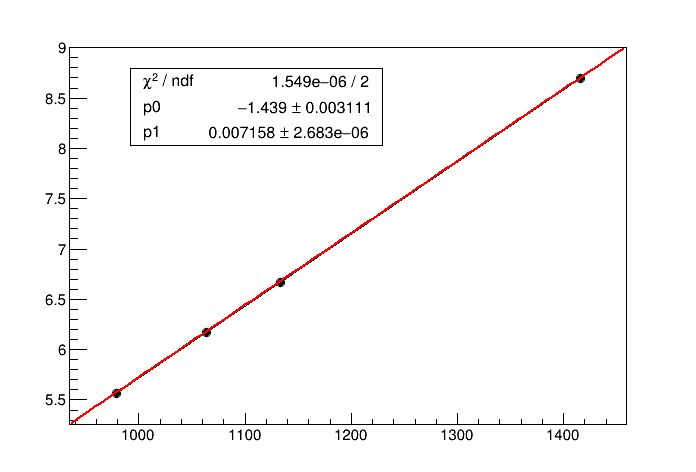

In [5]:
%jsroot off
c1->Clear();
TGraph *gc3 = (TGraph*)ipf->Get("dp3/gc3");
gc3->Draw();
gStyle->SetOptFit(1);
TPaveStats *ps = (TPaveStats*)gc3->FindObject("stats");
ps->SetX1NDC(0.188);
ps->SetY1NDC(0.692);
ps->SetX2NDC(0.549);
ps->SetY2NDC(0.854);
c1->Draw();

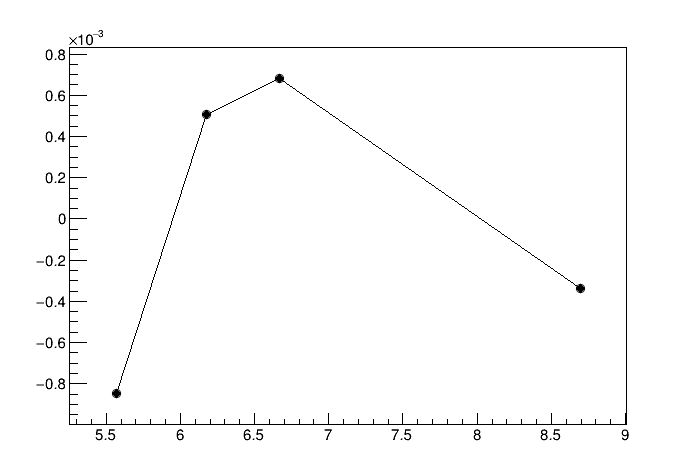

In [6]:
c1->Clear();
TGraph *gResidual3 = (TGraph*)ipf->Get("dp3/gResidual 3");
gResidual3->Draw();
c1->Draw();

### 所有条的刻度系数

In [7]:
TDirectory *dca = (TDirectory*)ipf->Get("calibration");
dca->ls();

TDirectoryFile*		calibration	calibration
 KEY: TGraph	gcp0;1	
 KEY: TGraph	gcp1;1	
 KEY: TGraph	gcchi2;1	
 KEY: TArrayD	cp0;1	object title
 KEY: TArrayD	cp1;1	object title
 KEY: TArrayD	cchi2;1	object title


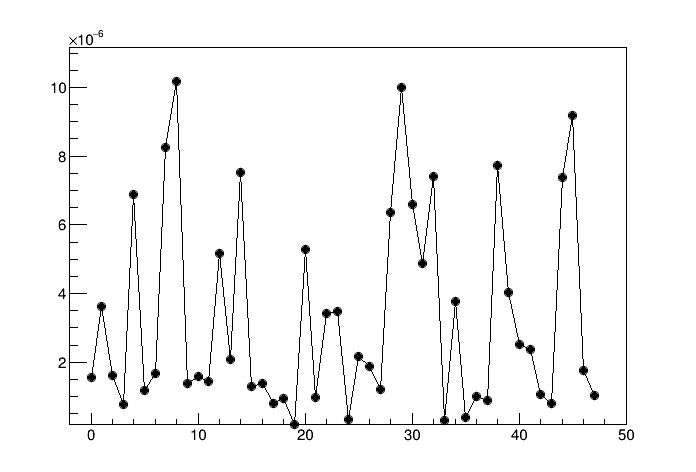

In [8]:
c1->Clear();
TGraph *gcchi2 = (TGraph*)ipf->Get("calibration/gcchi2");
gcchi2->Draw();
c1->Draw();

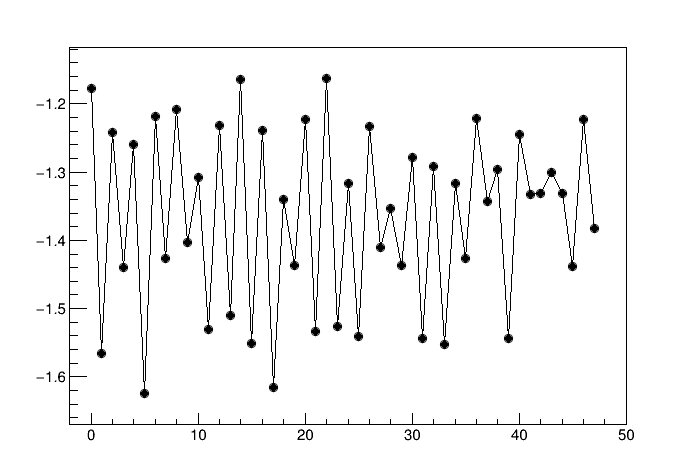

In [9]:
c1->Clear();
TGraph *gcp0 = (TGraph*)ipf->Get("calibration/gcp0");
gcp0->Draw();
c1->Draw();

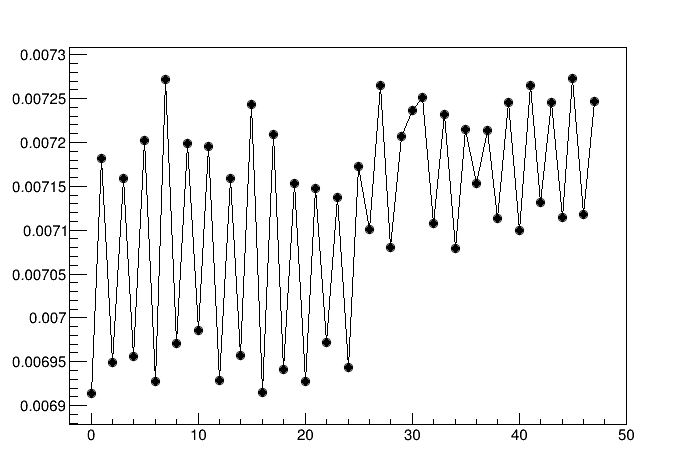

In [10]:
c1->Clear();
TGraph *gcp1 = (TGraph*)ipf->Get("calibration/gcp1");
gcp1->Draw();
c1->Draw();

In [11]:
%jsroot on
c1->Clear();
TMultiGraph *gRes = (TMultiGraph*)ipf->Get("PeakSigma");
gRes->Draw("PAL");
c1->Draw();

In [12]:
c1->Clear();
TMultiGraph *gChi = (TMultiGraph*)ipf->Get("PeakChi2");
gChi->Draw("PAL");
c1->Draw();

### 刻度效果

In [13]:
c1->Clear();
TH1F *hAll = (TH1F*)ipf->Get("hAll");
hAll->Draw();
c1->Draw();

In [14]:
c1->Clear();
TH1F *hAllFit = (TH1F*)ipf->Get("hAllFit");
hAllFit->Draw();
c1->Draw();

In [15]:
ipf->Close();